## GluonCV on SageMaker demo

This notebook 

Let's first import the necessary modules. 

In [1]:
!pip install gluoncv --pre -q

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import numpy as np
import cv2
import boto3
import json
import mxnet as mx
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt

### Object Detection with a pre-trained SSD model

In this demo we are going to perform inference on a GluonCV object detection model that has been deployed in Amazon SageMaker. We run this notebook on our laptop to capture image data from the webcam and to send it to the SageMaker endpoint. 

The endpoint is running the model `ssd_512_resnet50_v1_voc` which has the following structure:

In [3]:
net = model_zoo.get_model('ssd_512_resnet50_v1_voc', pretrained=False)
net

Model file is not found. Downloading.


100%|██████████| 57421/57421 [00:01<00:00, 39002.69KB/s]
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1159: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


SSD(
  (features): FeatureExpander(
  <Symbol group [ssd0_resnetv10_stage3_activation5, ssd0_resnetv10_stage4_activation2, ssd0_expand_reu0, ssd0_expand_reu1, ssd0_expand_reu2, ssd0_expand_reu3]> : 1 -> 6
  )
  (class_predictors): HybridSequential(
    (0): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ConvPredictor(
      (predictor): Conv2D(None -> 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (5): ConvPredictor(
      (predictor): Conv2D(None -> 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (box_predictors): HybridSequ

At this step we assume that the AWS credentials have been set beforehand. If this is not the case, make sure to set the following environment variables in the commandline before starting this notebook: `AWS_ACCESS_KEY_ID` `AWS_SECRET_ACCESS_KEY` and `AWS_SESSION_TOKEN`.

In the following lines of code, we list the endpoints that have been deployed in our account.

In [4]:
runtime= boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')
client.list_endpoints()['Endpoints']

[{'EndpointName': 'bcbs-logo-detection',
  'EndpointArn': 'arn:aws:sagemaker:us-east-1:291790195320:endpoint/bcbs-logo-detection',
  'CreationTime': datetime.datetime(2019, 12, 11, 4, 19, 59, 184000, tzinfo=tzlocal()),
  'LastModifiedTime': datetime.datetime(2019, 12, 11, 4, 27, 17, 129000, tzinfo=tzlocal()),
  'EndpointStatus': 'InService'}]

### Pretrained SSD model

Next we get the endpoint that has been deployed under the name `gluoncv-pretrained-object-detection-ssd`

In [5]:
for endpoint in  client.list_endpoints()['Endpoints']:
    if endpoint["EndpointName"] == "bcbs-logo-detection":
        gluoncv_endpoint = endpoint

Now we capture image data from the local webcam and send it to the endpoint. The endpoint will perform inference and return bounding boxes, class ids and confidence scores.

In [6]:
cap = cv2.VideoCapture(0)

while(True):
    ret, frame = cap.read()
    img = cv2.resize(frame, (512,512))
    payload = json.dumps(img.tolist())
    response = runtime.invoke_endpoint(EndpointName=gluoncv_endpoint['EndpointName'],
                                       Body=payload)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
    
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    ax = utils.viz.cv_plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], thresh=0.6, class_names=net.classes)
    
    cv2.imshow("image", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


### AWS Logo detection

We have deployed the GluonCV object detection model before in SageMaker under the name `gluoncv-demo-object-detection`. Now we retrieve this endpoint.

In [7]:
runtime= boto3.client('runtime.sagemaker')
client = boto3.client('sagemaker')
client.list_endpoints()['Endpoints']

for endpoint in  client.list_endpoints()['Endpoints']:
    if endpoint["EndpointName"] == "bcbs-logo-detection":
        gluoncv_endpoint = endpoint
        
gluoncv_endpoint

{'EndpointName': 'bcbs-logo-detection',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:291790195320:endpoint/bcbs-logo-detection',
 'CreationTime': datetime.datetime(2019, 12, 11, 4, 19, 59, 184000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2019, 12, 11, 4, 27, 17, 129000, tzinfo=tzlocal()),
 'EndpointStatus': 'InService'}

In the following code section, we retrieve frames from the webcam and send it to the SageMaker endpoint. We first have to convert the data into JSON format.

In [7]:
import time 
import json
cap = cv2.VideoCapture(0)
time.sleep(2)

while(True):
    ret, frame = cap.read()
    img = cv2.resize(frame, (512,512))
    payload = json.dumps(img.tolist())
    response = runtime.invoke_endpoint(EndpointName=gluoncv_endpoint['EndpointName'],
                                       Body=payload)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
    
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    ax = utils.viz.cv_plot_bbox(img, bounding_boxes[0], scores[0], class_IDs[0], thresh=0.6, class_names=["logo"])
    
    cv2.imshow("image", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [9]:
import cv2

cap = cv2.VideoCapture(0) 

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Display the resulting frame
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


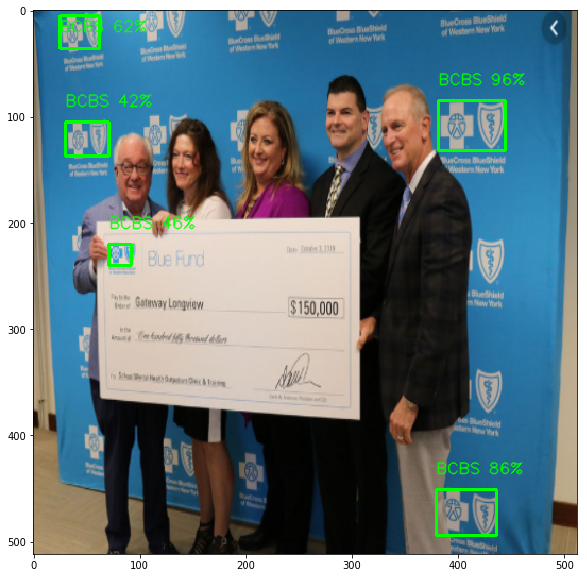

In [8]:
import math
import cv2

orig_img = cv2.imread('sample_images/blue_fund.PNG')
orig_img = cv2.resize(orig_img, (512,512))

img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

payload = json.dumps(img.tolist())
response = runtime.invoke_endpoint(EndpointName=gluoncv_endpoint['EndpointName'],
                                   Body=payload)
response_body = response['Body']
result = json.loads(response_body.read().decode())
[class_IDs, scores, bounding_boxes] = result
bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], 
                            class_IDs[0], thresh=0.4, class_names=["BCBS"],
                            colors = {0: (0, 255, 0)})
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))

<Figure size 1440x360 with 0 Axes>

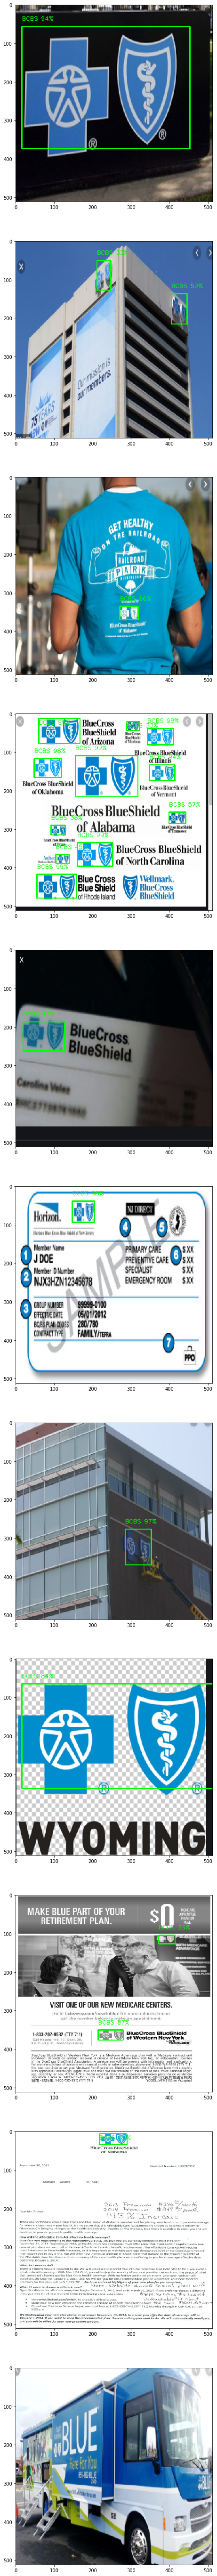

In [12]:
import glob
eval_images = glob.glob("sample_images/*")
n_images = len(eval_images)
cols = (int(math.sqrt(n_images)))*2

fig = plt.figure(figsize=(20,5))
imgs = []
for n, (image) in enumerate(eval_images[:n_images]):
    orig_img = cv2.imread(image)
    orig_img = cv2.resize(orig_img, (512,512))
    img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    payload = json.dumps(img.tolist())
    response = runtime.invoke_endpoint(EndpointName=gluoncv_endpoint['EndpointName'],
                                       Body=payload)
    response_body = response['Body']
    result = json.loads(response_body.read().decode())
    [class_IDs, scores, bounding_boxes] = result
   
    bounding_boxes, scores, class_IDs =  mx.nd.array(bounding_boxes), mx.nd.array(scores), mx.nd.array(class_IDs)
    ax = utils.viz.cv_plot_bbox(orig_img, bounding_boxes[0], scores[0], class_IDs[0], 
                                thresh=0.3, class_names=["BCBS"], colors = {0: (0, 255, 0)})
    imgs.append(orig_img)   
    
w=10
h=10
fig=plt.figure(figsize=(100, 100))
columns = 1
rows = 11
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB))
plt.show()